Import the required librairies for the work

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import warnings

Load the dataset for the work

In [115]:
my_file_location = r"gs://aw-insight-dev-live-20-zscratch/tomsha/profiles.csv"
df = pd.read_csv(my_file_location, encoding='cp1252')
df.columns = df.columns.str.strip()

print(df.dtypes)
print(df.head())
print(df.info())

age              int64
body_type       object
diet            object
drinks          object
drugs           object
education       object
essay0          object
essay1          object
essay2          object
essay3          object
essay4          object
essay5          object
essay6          object
essay7          object
essay8          object
essay9          object
ethnicity       object
height         float64
income           int64
job             object
last_online     object
location        object
offspring       object
orientation     object
pets            object
religion        object
sex             object
sign            object
smokes          object
speaks          object
status          object
dtype: object
   age       body_type               diet    drinks      drugs  \
0   22  a little extra  strictly anything  socially      never   
1   35         average       mostly other     often  sometimes   
2   38            thin           anything  socially        NaN   
3   23   

I have decided to create a model which predicts whether or not a participant smokes from their diet, how much they drink and how much they take drugs

no     43896
yes    16050
Name: smoker, dtype: int64


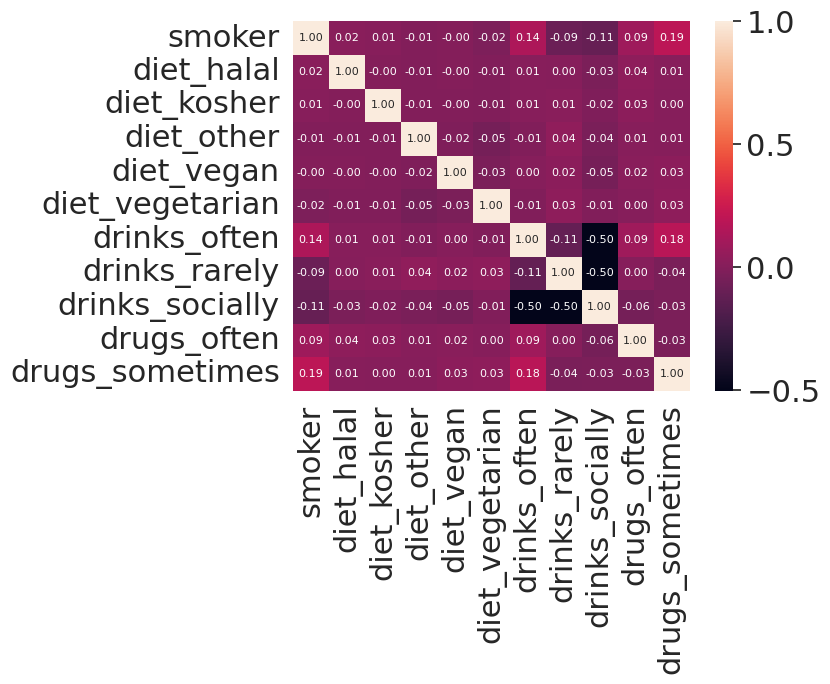

Feature 0: 11.931784
Feature 1: 5.033256
Feature 2: 0.906274
Feature 3: 0.860379
Feature 4: 22.783582
Feature 5: 759.995851
Feature 6: 338.517951
Feature 7: 138.055153
Feature 8: 322.766362
Feature 9: 1457.250518


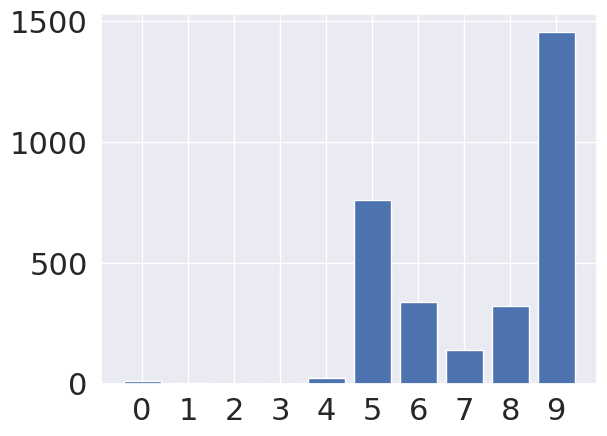

LogisticRegression()

In [137]:
df1 = df
#Turn the smoking column into a binary yes or no

df2['smoker'] = np.where((df1['smokes']!= 'no'), 'yes', df1['smokes'])
print(df2['smoker'].value_counts())
df2['smoker'] = df2['smoker'].replace('no', 0)
df2['smoker'] = df2['smoker'].replace('yes', 1)
#clean the drinks column to reduce the number of options
df2['drinks'] = df2['drinks'].replace(['very often', 'desperately'], 'often')
#clean the diet column to be more specific
df2['diet'] = df2['diet'].replace(['mostly anything' ,'strictly anything'], 'anything' )
df2['diet'] = df2['diet'].replace(['mostly vegetarian' ,'strictly vegetarian'], 'vegetarian' )
df2['diet'] = df2['diet'].replace(['mostly other' ,'strictly other'], 'other' )
df2['diet'] = df2['diet'].replace(['mostly vegan' ,'strictly vegan'], 'vegan' )
df2['diet'] = df2['diet'].replace(['mostly kosher' ,'strictly kosher'], 'kosher' )
df2['diet'] = df2['diet'].replace(['mostly halal' ,'strictly halal'], 'halal' )
#Reduce the size of the dataframe and only include the columns requires
df3 = df2[['smoker', 'diet', 'drinks', 'drugs']]
#convert the categorical data into indicator data
df3 = pd.get_dummies(df3, columns=['diet', 'drinks', 'drugs'], drop_first=True)
#draw a heat map to understand the effect of each variable
sns.heatmap(df3.corr(), annot = True, annot_kws={"fontsize":8}, fmt = '.2f')
plt.show()

#Split the features and the feature we are trying to predict
X = df3.drop(columns='smoker')
y = df3['smoker']

#Split the data into 75% train and 25% test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 27)

# prepare input data
def prepare_inputs(X_train, X_test):
 oe = OrdinalEncoder()
 oe.fit(X_train)
 X_train_enc = oe.transform(X_train)
 X_test_enc = oe.transform(X_test)
 return X_train_enc, X_test_enc
 
# prepare target
def prepare_targets(y_train, y_test):
 le = LabelEncoder()
 le.fit(y_train)
 y_train_enc = le.transform(y_train)
 y_test_enc = le.transform(y_test)
 return y_train_enc, y_test_enc
 
# feature selection
def select_features(X_train, y_train, X_test):
 fs = SelectKBest(score_func=chi2, k=5)
 fs.fit(X_train, y_train)
 X_train_fs = fs.transform(X_train)
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs


# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.xticks(np.arange(0, 10, step=1))
plt.show()

#adjust data to remove ineefective features
X = X.drop(columns = ['diet_halal', 'diet_kosher', 'diet_other', 'diet_vegan', 'diet_vegetarian'])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 27)

#Create the model
from sklearn.linear_model import LogisticRegression
cc_lr = LogisticRegression()
cc_lr.fit(X_train, y_train)


Print out the coefficents and intercept

In [140]:
print(cc_lr.coef_)
print(cc_lr.intercept_)

[[-0.20416486 -1.52404091 -0.93154359  1.99671346  1.14693554]]
[-0.41548413]


Predict the outcomes of the test data

In [141]:
y_pred = cc_lr.predict(X_test)
# print('predicted classes: ', y_pred)

# Print out the true outcomes for the test data
print('true classes: ', y_test)

# Print out the confusion matrix here
from sklearn.metrics import confusion_matrix
print(f'Confusion matrix: {confusion_matrix(y_test, y_pred)}')

true classes:  37541    0
44629    0
26892    1
49970    1
29073    0
        ..
3028     1
1930     0
49155    1
54041    0
20181    1
Name: smoker, Length: 14987, dtype: int64
Confusion matrix: [[10727   243]
 [ 3637   380]]


Print out the model accuracy scores

In [142]:
# Print accuracy here:
from sklearn.metrics import accuracy_score
print(f'Model accuracy score: {accuracy_score(y_test, y_pred)}')

# precision:
from sklearn.metrics import precision_score
print(f'Model precision score: {precision_score(y_test, y_pred)}')

# recall: 
from sklearn.metrics import recall_score
print(f'Model recall score: {recall_score(y_test, y_pred)}')

# Print F1 score here:
from sklearn.metrics import f1_score
print(f'Model f1 score: {f1_score(y_test, y_pred)}')


Model accuracy score: 0.7411089610996197
Model precision score: 0.6099518459069021
Model recall score: 0.09459795867562858
Model f1 score: 0.16379310344827586
